
# Diseño de software para cómputo científico

----

## Unidad 4: Optimización, paralelismo, concurrencia y cómputo distribuido en alto nivel.


## Agenda de la Unidad 4

- Multithreading, Paralelismo, Concurrencia.
- Optimización y Optimización prematura. Cuellos de botella, Legibilidad vs. Optimización.
- **Profiling.**
- Compiladores justo a tiempo (numba).
- Cómputo distribuido con Dask.

### Profiling 

> Es la investigación del comportamiento de un programa de ordenador usando información reunida desde el análisis dinámico del mismo. 
> 
> El objetivo es averiguar el tiempo dedicado a la ejecución de diferentes partes del programa para detectar los puntos problemáticos y las áreas dónde sea posible llevar a cabo una optimización del rendimiento.

### Benchmark

> Es el resultado de la ejecución de un programa informático o un conjunto de programas en una máquina, con el objetivo de estimar el rendimiento de un elemento concreto, y poder comparar los resultados con máquinas similares. 

## Por qué hacemos profiling?

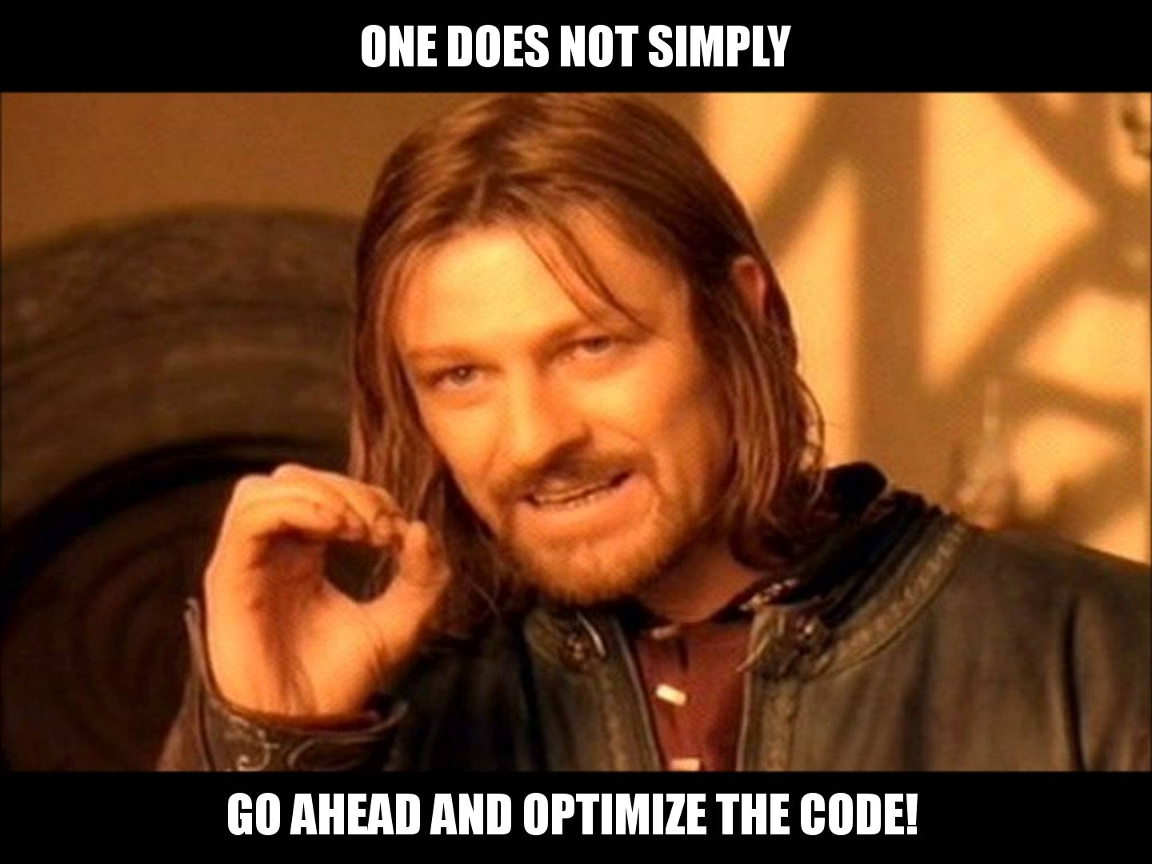

## Optimización responsable.


> "La optimización temprana es la raíz de todo mal."
>
>           Donald E. Knuth

1. ¿Cuánto del recurso $X$ se usa?
2. ¿Cómo se gasta exactamente esta cantidad de $X$?

$$X \in \{CPU, RAM, I/O, power, \dots \}$$

**¡Perfilamos el código para encontrar respuestas a estas preguntas!**

## Cuellos de botella

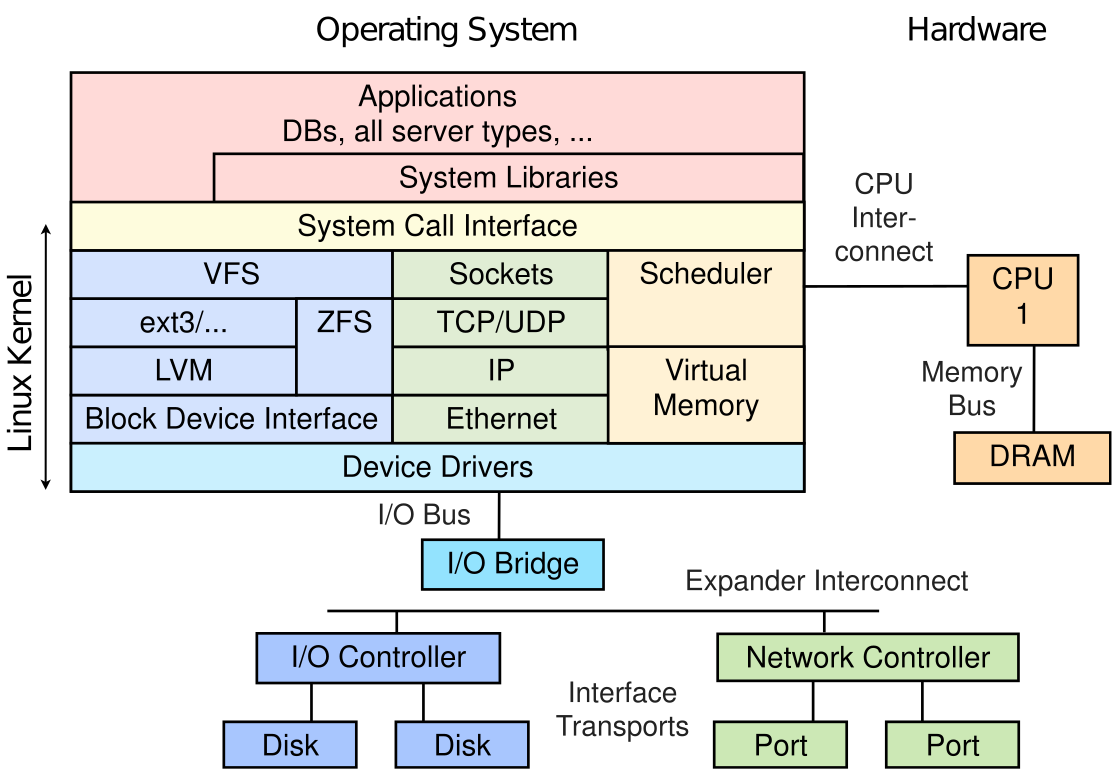

## Cuellos de botella

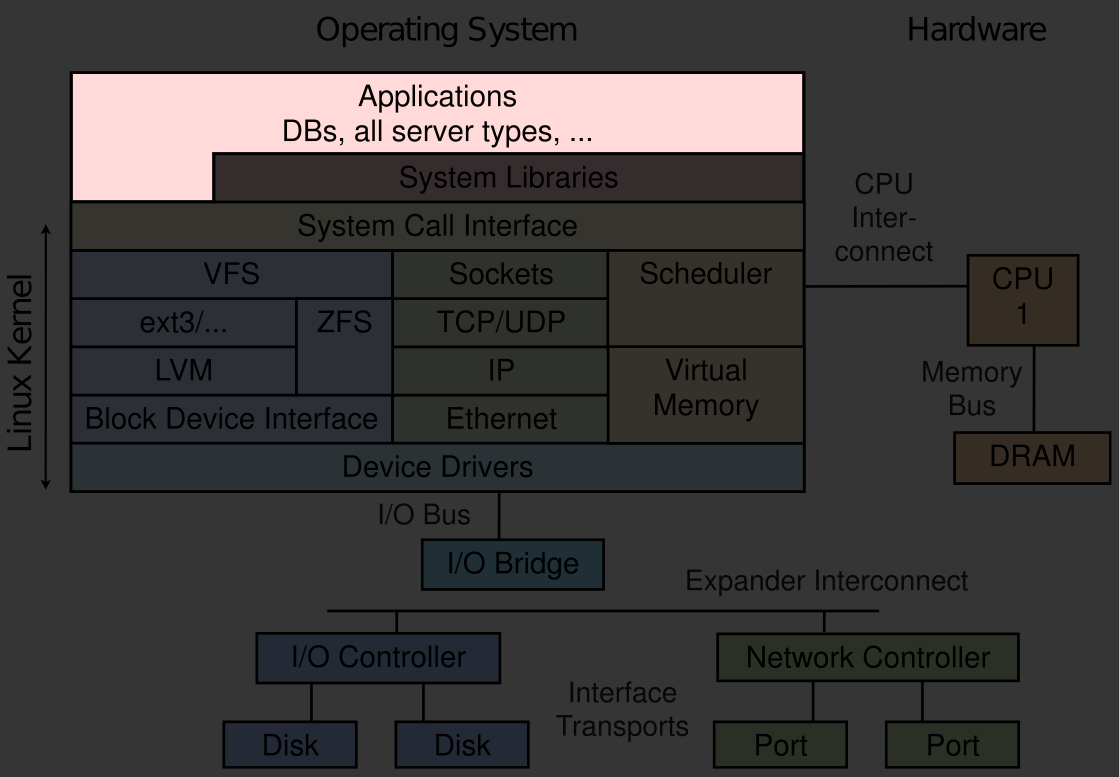

## Clasificación de herramientas de profiling

- **¿Qué se perfila?** - CPU, RAM, I/O, bandwith.
- **¿Cómo se perfila?** - Determinsta vs Estadístico.
- **¿Qué granularidad?** - Nivel de aplicación, Nivel de método/función, Nivel de línea.
- **Tipo de informe** - Texto, colores, call-graphs, Square-maps.

## Herramientas de profiling en Python

- **snippet-level:** `timeit` (stdlib)
- **Deterministic Method/Function-level:** `cProfile` y `profile` (stdlib).
- **Statistical Method/Function-level:** `statsprof.py` (pypi).
- **Run time, line-level, deterministic:** `line_profiler` (pypi).

- **Memory, line-level, ±deterministic:** `memory_profiler` (pypi)
- **Memory, method-level, deterministic:** `pympler` (pypi), `guppy3` (pypi).

## Herramientas "más" genéricas.

### Python extensions — use corresponding profilers!
- gprof (GCC)
- gperftools (Google)

### Generic or special-purpose profilers

- **Application-level, aggregate:** `time` (POSIX), `perf` (Linux)
- **Dynamic analysis with Valgrind:** `{Call,Cache}grind` / `Massif`

### High performance computing (HPC)

- **Measurement:** PAPI, Score-P, . . .
- **Analysis:** Vampir, TAU, Scalasca, . .

## Herramientas "más" genéricas.

### Python extensions — use corresponding profilers!
- gprof (GCC)
- gperftools (Google)

### Generic or special-purpose profilers

- **Application-level, aggregate:** **`time`** (POSIX), `perf` (Linux)
- **Dynamic analysis with Valgrind:** **`{Call,Cache}grind`** / `Massif`

### High performance computing (HPC)

- **Measurement:** PAPI, Score-P, . . .
- **Analysis:** Vampir, TAU, Scalasca, . .

## Empecemos con un ejemplo en caja negra con **time**

### printdf.py

El programa imprime por pantalla un dataframe en formato Pickle o *CSV*

```bash
$time python printdf.py df.csv
...
real	0m1,601s
user	0m1,087s
sys	0m0,510s
```

```bash
$ time python printdf.py df.csv df.pkl
...
real	0m1,547s
user	0m2,334s <<<<< WAT?
sys	0m0,814s
```

## Los secretos del *time*

- **real** es el tiempo del reloj de pared (de principio a fin de la llamada)
- **user** es la cantidad de tiempo de CPU gastado en código de modo de usuario
  (fuera del núcleo) dentro del proceso
- **sys** es la cantidad de tiempo de CPU que pasa en el núcleo (por ejemplo, en
    llamadas al sistema, asignación de memoria, E/S, etc.) dentro del proceso
- **user + sys** te dice cuánto tiempo de CPU real proceso consumido

$$
\Rightarrow real \ne user + sys
$$

## Microbenchmarks con `timeit`

**fib1.py**
```python
def fib(n):
    a, b = 0, 1
    for _ in range(n):
        a, b = b, a + b
    return a
```

**fib2.py**

```python
def fib(n):
    if n > 1:
        return fib(n - 1) + fib(n - 2)
    else:
        return n
```

## Microbenchmarks con `timeit` - **fib1.py** Vs. **fib2.py**


```bash
$ python -m timeit -s 'from fib1 import fib' 'fib(35)'
200000 loops, best of 5: 1.44 usec per loop
    
$ python -m timeit -n 3 -s 'from fib2 import fib' 'fib(35)'
3 loops, best of 5: 2.82 sec per loop
```


## Microbenchmarks con `timeit` - Mejoramos **fib2.py**

**fib3.py**

```python
def fib(n, m={0: 0, 1: 1}):
    if n not in m:
        m[n] = fib(n - 1) + fib(n - 2)
    return m[n]
```

## Microbenchmarks con `timeit` - **fib1.py** Vs. **fib3.py**

```bash
$ python -m timeit -s 'from fib1 import fib' 'fib(35)'
200000 loops, best of 5: 1.44 usec per loop


$ python -m timeit -s 'from fib3 import fib' 'fib(35)'
2000000 loops, best of 5: 115 nsec per loop
```


## Microbenchmarks con `timeit` - **fib1.py** Vs. **fib3.py** (Detalle 1/2)

```bash 
$ python -m timeit -v -s 'from fib1 import fib' 'fib(35)'
1 loop -> 3.18e-06 secs
2 loops -> 3.9e-06 secs
5 loops -> 8.12e-06 secs
10 loops -> 1.56e-05 secs
...
20000 loops -> 0.0294 secs
50000 loops -> 0.0723 secs
100000 loops -> 0.144 secs
200000 loops -> 0.291 secs

raw times: 289 msec, 288 msec, 290 msec, 291 msec, 292 msec

200000 loops, best of 5: 1.44 usec per loop
```


## Microbenchmarks con `timeit` - **fib1.py** Vs. **fib3.py** (Detalle 2/2)

```bash 
$ python -m timeit -v -s 'from fib3 import fib' 'fib(35)'
1 loop -> 1.78e-05 secs
2 loops -> 8.9e-07 secs
5 loops -> 1.07e-06 secs
10 loops -> 1.47e-06 secs
...
200000 loops -> 0.0232 secs
500000 loops -> 0.0583 secs
1000000 loops -> 0.115 secs
2000000 loops -> 0.231 secs

raw times: 231 msec, 233 msec, 232 msec, 233 msec, 233 msec

2000000 loops, best of 5: 116 nsec per loop
```


Es importante fijarse que se mide **lo que se quiere medir**

## Microbenchmarks con `timeit` - -- Closed form solution!


**fib4.py**
```python
import math

sqrt5 = math.sqrt(5)
phi = (1 + sqrt5) / 2

def fib(n):
    return int((phi**n - (-phi)**-n) / sqrt5)
```

## Microbenchmarks con timeit - fib1.py Vs. fib4.py

```bash
$ python -m timeit -s 'from fib1 import fib' 'fib(70)'
100000 loops, best of 5: 2.86 usec per loop

$ python -m timeit -s 'from fib4 import fib' 'fib(70)'
500000 loops, best of 5: 456 nsec per loop
```


## Microbenchmarks con timeit - fib1.py Vs. fib4.py - CMP

```bash
$ python -c 'from fib1 import fib; print(fib(70), fib(80))'
190392490709135 23416728348467685

$ python -c 'from fib4 import fib; print(fib(70), fib(80))'
190392490709135 23416728348467744
```

**Que halgo funcione rapido no significa que funcione bien**

## Referencias

- http://zaytsev.net/confidence-2.zip
- https://es.wikipedia.org/wiki/An%C3%A1lisis_de_rendimiento_de_software
- https://es.wikipedia.org/wiki/Benchmark_(inform%C3%A1tica)
- http://www.brendangregg.com/linuxperf.html